-----------------
Fai un programa en Python que coa imaxe escaneada:

- Identifica os cuadrilateros da imaxe.

- Conta o número de "circulos" e encerraos dentro dun cuadrilatero

Imagen cargada correctamente. Dimensiones: (1753, 1240)


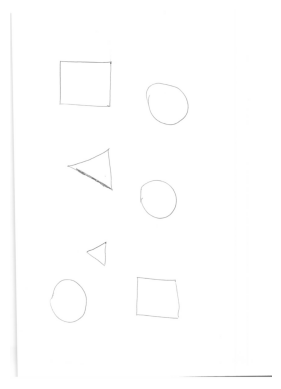

In [20]:


import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img = cv.imread("../../docs/Escaneo-cargador.jpg",cv.IMREAD_GRAYSCALE)


if img is None:
    print("Error: No se encontró la imagen. Revisa el nombre o la ruta.")
else:
    print(f"Imagen cargada correctamente. Dimensiones: {img.shape}")
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)) # la convierto a rgb ya que el cv toma el bgr 
    plt.axis('off')
    plt.show()

In [21]:
# Función auxiliar par no repetir codifo cada rato
def mostrar_imagen(titulo, imagen, cmapa='gray'):
    plt.figure(figsize=(10, 6))
    plt.imshow(imagen, cmap=cmapa)
    plt.title(titulo)
    plt.axis('off') 
    plt.show()



Preprocesamiento 

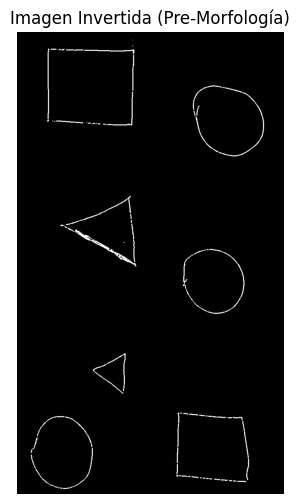

In [31]:
img = img[200:1500, 150:900] 

    # Desenfoque de Mediana (MedianBlur), ya que no borra los bordes
blurMedian = cv.medianBlur(img, 5)
#
# Umbral Adaptativo (Adaptive Threshold), esto Se adapta a la iluminación de cada zona , es bueno poara lo que etsamos haciendo ya que es para scaner 
# BlockSize=11, C=2 (Parámetros del notebook de referencia)
th3 = cv.adaptiveThreshold(blurMedian, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, \
                            cv.THRESH_BINARY, 11, 2)

    # 4. Invertir colores (Bitwise Not)
    #TODO cv necesita OBJETOS BLANCOS y FONDO NEGRO !!!!para encontrar contornos 
imaxeInvertido = cv.bitwise_not(th3)

mostrar_imagen('Imagen Invertida (Pre-Morfología)', imaxeInvertido)

Limpieza (Morfologica)

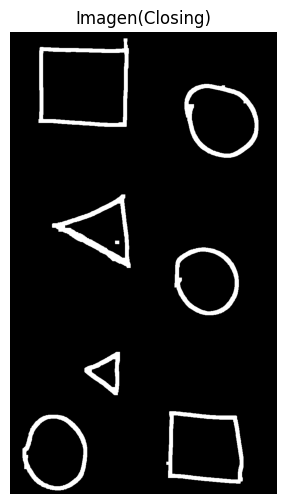

In [33]:
# Definir los Kernels
kernel_dilatacion = np.ones((9,9), np.uint8) # 5x5 para engordar
kernel_limpieza = np.ones((7,7), np.uint8)   # 7x7 para limpiar

# DILATACIÓN: Engorda las líneas para unir trazos rotos
dilation = cv.dilate(imaxeInvertido, kernel_dilatacion, iterations=1)

# OPENING (Apertura): Quita ruido externo (puntos blancos sueltos)
opening = cv.morphologyEx(dilation, cv.MORPH_OPEN, kernel_limpieza)

# CLOSING (Cierre): Tapa agujeros negros dentro de las líneas blancas
closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel_limpieza)

mostrar_imagen('Imagen(Closing)', closing)

Determinar los contornos 

Número de contornos encontrados: 7
Círculos detectados: 3
Cuadriláteros detectados: 2


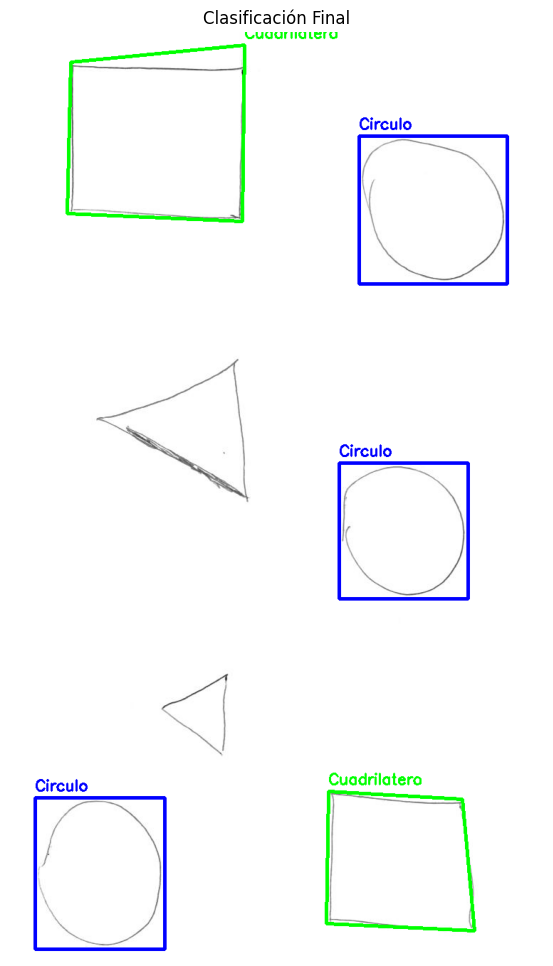

In [39]:
#RETR_EXTERNAL porque solo nos interesan la figura no todo los bordes 
cnts, hierarchy = cv.findContours(closing, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

print(f"Número de contornos encontrados: {len(cnts)}")

# la imagen a color para dibujar encima
resultado = cv.cvtColor(img, cv.COLOR_GRAY2BGR) # Usamos la original de fondo
num_circulos = 0
num_cuadrilateros = 0

for contorno in cnts:
    
    area = cv.contourArea(contorno)
    
    # Calcular Perímetro
    perimeter = cv.arcLength(contorno, True)
    

    '''
    epsilon: 
    es la distancia máxima que permitimos que la nueva figura simplificada 
    se aleje del dibujo original. Controla cuánto simplificamos la forma.
    '''

    epsilon = 0.03 * perimeter 
    approx = cv.approxPolyDP(contorno, epsilon, True)
    vertices = len(approx)

    
    circularity = 4 * np.pi * (area / (perimeter * perimeter))

    if circularity > 0.8:
        num_circulos += 1
        x, y, w, h = cv.boundingRect(contorno)
        cv.rectangle(resultado, (x, y), (x + w, y + h), (255, 0, 0), 3) 
        cv.putText(resultado, "Circulo", (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    elif vertices == 4:
        num_cuadrilateros += 1
        cv.drawContours(resultado, [approx], -1, (0, 255, 0), 3)
        cv.putText(resultado, "Cuadrilatero", (approx[0][0][0], approx[0][0][1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    

print(f"Círculos detectados: {num_circulos}")
print(f"Cuadriláteros detectados: {num_cuadrilateros}")

plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(resultado, cv.COLOR_BGR2RGB))
plt.title("Clasificación Final")
plt.axis('off')
plt.show()



<h1 align="center" style="background: linear-gradient(90deg, #0f2027, #203a43, #2c5364); color: #ffffff; padding: 20px; border-radius: 15px;">
 APUNTES 
</h1>


------------

# 🟦 Procesamiento de Imágenes 

---

## <span style="color:#1f6feb;">🎨 Escala de Grises</span>

Al ordenador le da igual si el cuadrado es **rojo** o **verde**.  
Solo le importa la **forma**.

Al pasar la imagen a **escala de grises**, eliminamos el color y nos quedamos únicamente con la **intensidad de luz** de cada píxel (qué tan claro u oscuro es).

Esto simplifica el procesamiento de la imagen.

---

## <span style="color:#1f6feb;">⚫⚪ Binarización (Blanco y Negro / Umbral)</span>

En este paso convertimos la imagen en **solo dos colores**:

- **Blanco puro** → objetos de interés  
- **Negro puro** → fondo  

Mediante un **umbral**, separamos claramente los objetos del fondo.

---

## <span style="color:#1f6feb;">✏️ Contornos</span>

OpenCV recorre la imagen y:

- Busca los píxeles blancos
- Une los que están conectados
- Dibuja una línea alrededor del objeto

Esa línea que rodea al objeto se llama **contorno**.

---

## <span style="color:#1f6feb;">🔑 Aproximación (La clave del ejercicio)</span>

Una vez obtenido el contorno, le preguntamos a OpenCV:

**¿Cuántas esquinas tiene esta figura?**

Según el número de esquinas:

- **4 esquinas** → es un **cuadrilátero**
- **Muchas esquinas (más de 8 o 10)** → probablemente es un **círculo**

Esto ocurre porque un círculo digital es, en realidad, un **polígono con muchos lados pequeños**.

---

### <span style="color:#1f6feb;">📌 Resumen</span>

1. Escala de grises → elimina el color  
2. Binarización → separa objeto y fondo  
3. Contornos → detecta los bordes  
4. Aproximación → identifica la forma
